* [Purpose] The proposed MW-GA-GRU model is compared with ARIMA, GARCH, ANN, SVR, RNN, LSTM, and GRU based on the data of copper price in Changjiang.

### Import related package.

In [8]:
## Data preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Visulization
import matplotlib.pyplot as plt

## ARIMA and SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ndiffs
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm ##Automatically decide on ARIMA configuration
import statsmodels.api as sm

## The warning infomation dialog
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Flatten, Input
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Metric

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
tf.compat.v1.keras.backend.set_session(sess)

In [9]:
def read(path):
    return pd.read_csv(path)

#### Read performance indicator data

In [3]:
performance = pd.read_csv("result_data.csv")
performance.columns = ["Actual", "MW-GA-GRU"]

#### Create function "read()" to read the training data

In [118]:
path = "WeeklyFinalData.csv"
data = read(path)
train = data["CCSP"][:-91]
test = data["CCSP"][-95:]
data = data["CCSP"]

### Build the mention above model like ARIMA, GARCH, ANN, SVR, RNN, LSTM, and GRU.

### Model the SARIMA model

In [119]:
model = sm.tsa.statespace.SARIMAX(train, order=(1,1,0), seasonal_order=(0,1,2,53))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    CCSP   No. Observations:                  388
Model:             SARIMAX(1, 1, 0)x(0, 1, [1, 2], 53)   Log Likelihood               -2862.482
Date:                                 Wed, 04 Aug 2021   AIC                           5732.963
Time:                                         05:34:29   BIC                           5748.208
Sample:                                              0   HQIC                          5739.041
                                                 - 388                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0316      0.027      1.159      0.246      -0.022       0.085
ma.S.L53      -0.2406      0.016    -14.642      0.000      -0.273      -0.208
ma.S.L106     -0.1581      0.012    -12.695      0.000      -0.183      -0.134
sigma2       1.75e+06   9.45e+04     18.527      0.000    1.57e+06    1.94e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.97   Jarque-Bera (JB):               272.32
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast

In [120]:
pre = model_fit.forecast(99)

In [123]:
pre.reset_index(inplace=True, drop=True)

In [126]:
pre[4:]
pre.reset_index(inplace=True, drop=True)

In [128]:
performance["SARIMA"]=pre

# Read and pre-process data

In [29]:
def buildTrain(train, pastWeek=4, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
       
        X = np.array(train.iloc[i:i+defaultWeek])
        X = np.append(X,train["CCSP"].iloc[i+defaultWeek:i+pastWeek])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek:i+pastWeek+futureWeek]["CCSP"]))
    
    return np.array(X_train), np.array(Y_train)

In [30]:
def get_data():
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data)
    
    ## Data split
    x_train = x_data[0:int(x_data.shape[0]*0.8)]
    x_test = x_data[int(x_data.shape[0]*0.8):]
    
    y_train = y_data[0:int(y_data.shape[0]*0.8)]
    y_test = y_data[int(y_data.shape[0]*0.8):]
    
    return (x_train, x_test, y_train, y_test)

In [31]:
sc = MinMaxScaler(feature_range = (0, 1))

In [41]:
x_train, x_test, y_train, y_test = get_data()
y_train = y_train[:,3].reshape(-1,1)
y_test = y_test[:,3].reshape(-1,1)

x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)
y_train_scaled = sc.fit_transform(y_train)

In [42]:
performance = pd.DataFrame()
performance["Actual"] = y_test.flatten()

# Modeling for SVR

In [43]:
from sklearn.svm import SVR

In [44]:
svr_rbf = SVR(kernel = 'rbf', C=1e3 , gamma = 0.1)
svr_rbf.fit(x_train_scaled, y_train_scaled)

SVR(C=1000.0, gamma=0.1)

In [45]:
SVR_predict = svr_rbf.predict(x_test_scaled).reshape(-1,1)
performance["SVR"] = sc.inverse_transform(SVR_predict).flatten()

# 3. Modeling for ANN

### ANN

In [47]:
def buildTwoLayerNN(input_shape):

    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(units=36, activation ="relu", input_shape=(input_shape,)))
    model.add(Dense(units=1)) 

    model.compile(optimizer="Adam", loss="mean_squared_error")

    return model

In [48]:
input_shape = x_train_scaled.shape[1]
model = buildTwoLayerNN(input_shape)

In [49]:
model.fit(x_train_scaled, y_train_scaled, epochs=100, verbose=0)

In [50]:
# model.save("ann_model_weight.h5")
ANN_predict = model.predict(x_test_scaled)
performance["ANN"] = sc.inverse_transform(ANN_predict).flatten()

# Prepare the corresponding data for RNN-based NN

In [69]:
def buildTrain(train, pastWeek, futureWeek=4, defaultWeek=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureWeek-pastWeek):
        
        X = np.array(train.iloc[i:i+pastWeek,:])
        
        X_train.append(X.reshape(X.size))
        Y_train.append(np.array(train.iloc[i+pastWeek+futureWeek-1]["CCSP"]))
    return (np.array(X_train), np.array(Y_train))

In [104]:
def get_data(timeLag):
    
    ## Read weekly copper price data
    path = "WeeklyFinalData.csv"
    data = read(path)
    
    date = data["Date"]
    data.drop("Date", axis=1, inplace=True)
    
    ## Add time lag (pastWeek=4, futureWeek=1)
    x_data, y_data = buildTrain(data, timeLag)
    
    ## Data split
    x_train = x_data[0:int(x_data.shape[0]*0.8)]
    x_test = x_data[int(x_data.shape[0]*0.8):]
    
    y_train = y_data[0:int(y_data.shape[0]*0.8)]
    y_test = y_data[int(y_data.shape[0]*0.8):]
    
    return (x_train, x_test, y_train, y_test)

In [105]:
x_train, x_test, y_train, y_test = get_data(4)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
## The number of forecasting variable (# of variable)
nb_input_factor = 15

## Data transformation
x_train_scaled = sc.fit_transform(x_train).reshape(-1,4,nb_input_factor)
x_test_scaled = sc.transform(x_test).reshape(-1,4,nb_input_factor)
y_train_scaled = sc.fit_transform(y_train)

In [106]:
print("x_train:",x_train_scaled.shape)
print("x_test:",x_test_scaled.shape)
print("y_train:",y_train_scaled.shape)
print("y_test:",y_test.shape)

x_train: (376, 4, 15)
x_test: (95, 4, 15)
y_train: (376, 1)
y_test: (95, 1)


# 4. Modeling for RNN

In [107]:
import tensorflow as tf
from tensorflow import keras

In [108]:
from keras.layers import SimpleRNN

In [132]:
def buildRNN(shape):
    
    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(SimpleRNN(36, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [133]:
model = buildRNN(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
RNN_predict = model.predict(x_test_scaled)
performance["RNN"] = sc.inverse_transform(RNN_predict).flatten()

# 5. Modeling for LSTM

In [112]:
from keras.layers import LSTM

In [113]:
def buildLSTM(shape):
    
    model = Sequential()
    model.add(LSTM(36, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [114]:
model = buildLSTM(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
LSTM_predict = model.predict(x_test_scaled)
performance["LSTM"] = sc.inverse_transform(LSTM_predict).flatten()

# 6. Modeling for GRU

In [115]:
from keras.layers import GRU

In [116]:
def buildGRU(shape):
    
    model = Sequential()
    model.add(GRU(36, input_shape=(shape[1], shape[2])))
    model.add(Dense(1))
    model.compile(optimizer="Adam", loss="mse")
#     model.summary()
    return model

In [117]:
model = buildGRU(x_train_scaled.shape)
model.fit(x_train_scaled, y_train_scaled, epochs=300, batch_size=14, verbose=0)
GRU_predict = model.predict(x_test_scaled)
performance["GRU"] = sc.inverse_transform(GRU_predict).flatten()

# Plot a graph comparing the predicted value with the actual value.

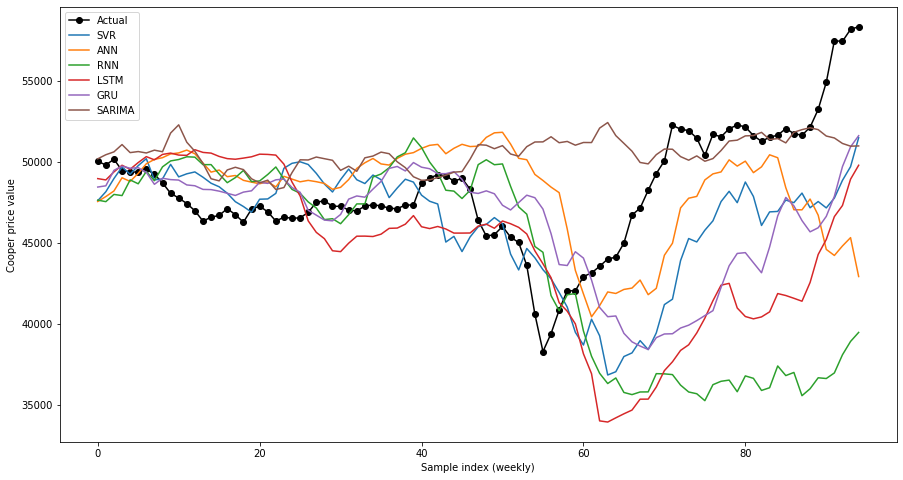

In [134]:
plt.figure(figsize=(15,8))

plt.plot(range(performance["Actual"].shape[0]), performance["Actual"], "-o",color='black', label = 'Actual')

for i in range(1,performance.shape[1]):
    t_data = performance.iloc[:,i]
    plt.plot(t_data, label=performance.columns[i])

plt.legend()
plt.xlabel("Sample index (weekly)")
plt.ylabel("Cooper price value")
plt.savefig('RMSE.png')

# Create the function to evaluate the performance of each model based on the RMSE, MAE, MAPE, and the accuracy from 500 to 3000 tolerance.

In [139]:
evaluation_results = pd.DataFrame(columns=["Model","MAE","MAPE","RMSE"])

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()
mse = tf.keras.losses.MeanSquaredError()

for i in range(1,performance.shape[1]):
    
    val_mae = mae(performance["Actual"], performance.iloc[:,i]).numpy()
    val_mape = mape(performance["Actual"], performance.iloc[:,i]).numpy()
    val_rmse = tf.math.sqrt(mse(performance["Actual"], performance.iloc[:,i])).numpy()
    val_max_error = tf.reduce_max(mae(performance["Actual"], performance.iloc[:,i])).numpy()
    accuracy = list()
    
    for threshold in range(500,3001,500):
        
        y_true = performance["Actual"]
        y_pred = performance.iloc[:,i]
        
        total_times = y_true.shape[0]
        correct_times = 0
        
        for _ in range(total_times): 

            correct_times = np.count_nonzero(abs(y_true-y_pred) < threshold)
        
        accuracy.append(correct_times/total_times)

    
    new_result = pd.DataFrame({

        "Model" : [performance.columns[i]],
        "MAE" : [val_mae],
        "MAPE" : [val_mape],
        "RMSE" : [val_rmse],
        "Maximum error":[val_max_error],
        "Accuracy(500)" : accuracy[0],
        "Accuracy(1000)" : accuracy[1],
        "Accuracy(1500)" : accuracy[2],
        "Accuracy(2000)" : accuracy[3],
        "Accuracy(2500)" : accuracy[4],
        "Accuracy(3000)" : accuracy[5]
        
    })

    evaluation_results = evaluation_results.append(new_result, ignore_index=True)
evaluation_results

,Model,MAE,MAPE,RMSE,Maximum error,Accuracy(500),Accuracy(1000),Accuracy(1500),Accuracy(2000),Accuracy(2500),Accuracy(3000)
0,SVR,3359.374023,6.846053,4318.430965,3359.374023,0.094737,0.189474,0.315789,0.452632,0.484211,0.547368
1,ANN,3658.720947,7.563893,4713.149902,3658.720947,0.031579,0.052632,0.157895,0.284211,0.463158,0.610526
2,RNN,6409.056641,12.721907,9053.962891,6409.056641,0.126316,0.200000,0.231579,0.326316,0.442105,0.463158
3,LSTM,5254.456055,10.645926,6810.735840,5254.456055,0.063158,0.168421,0.231579,0.305263,0.357895,0.421053
4,GRU,3783.215820,7.684668,5214.731445,3783.215820,0.115789,0.263158,0.368421,0.494737,0.547368,0.621053
5,SARIMA,3195.841797,6.980060,4345.696492,3195.841797,0.147368,0.252632,0.347368,0.463158,0.526316,0.621053


In [67]:
performance.to_csv("result.csv", index=False)

In [140]:
evaluation_results.to_csv("performance_indicator.csv", index=False)